In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from math import sqrt, sin, cos, acos, pi
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import folium
from IPython.display import display

# Подготовка данных

In [ ]:
data = pd.read_csv('drive/MyDrive/Датасеты/ALL_SPB_STOPS.csv', sep=';', encoding='cp1251', engine='python', quoting=3)

In [ ]:
data.head()

,ID_STOP,STOP_NAME,LATITUDE,LONGITUDE
0,100101,Пр.Ветеранов-1,59.841604,30.253984
1,100102,Пр.Ветеранов-2,59.842042,30.250084
2,100103,Ленинский пр.-1,59.851683,30.268385
3,100104,Ленинский пр.-2,59.849710,30.268348
4,100105,Автово,59.867292,30.261133


In [ ]:
data.dtypes

ID_STOP        int64
STOP_NAME     object
LATITUDE     float64
LONGITUDE    float64
dtype: object

In [ ]:
# расстояние в метрах от одной точки до другой
def coordinate_distance(latitude1, longitude1, latitude2, longitude2):
  t_radius = 6371.3
  R_Lat1, R_Lat2 = latitude1 * pi / 180, latitude2 * pi / 180
  R_Long1, R_Long2 = longitude1 * pi / 180, longitude2 * pi / 180
  return round(acos(
      cos(R_Lat1) * cos(R_Long1) * cos(R_Lat2) * cos(R_Long2) +
      cos(R_Lat1) * sin(R_Long1) * cos(R_Lat2) * sin(R_Long2) +
      sin(R_Lat1) * sin(R_Lat2)
  ) * t_radius * 1000)

# data = data.to_numpy(dtype=float)

# stops = data[data['ID_STOP'] // 1000 != 100 &
            #  d(data['LATITUDE'].astype(float), data['LONGITUDE'].astype(float), 59.851683, 30.268385) <= 1000]

Возьмём за стартовую точку станцию Автово.

In [ ]:
data['distance'] = data.apply(lambda row: coordinate_distance(59.867292, 30.261133, row['LATITUDE'], row['LONGITUDE']), axis=1)

In [ ]:
data.head()

,ID_STOP,STOP_NAME,LATITUDE,LONGITUDE,distance
0,100101,Пр.Ветеранов-1,59.841604,30.253984,2884
1,100102,Пр.Ветеранов-2,59.842042,30.250084,2875
2,100103,Ленинский пр.-1,59.851683,30.268385,1782
3,100104,Ленинский пр.-2,59.849710,30.268348,1996
4,100105,Автово,59.867292,30.261133,0


In [ ]:
data = data[data['distance'] <= 1000]

In [ ]:
data = data[data['ID_STOP'] // 1000 != 100]

In [ ]:
data.head()

,ID_STOP,STOP_NAME,LATITUDE,LONGITUDE,distance
115,1341,АВТОВСКАЯ УЛ. [72],59.869850,30.270802,610
224,14715,"УЛ .ЗЕНИТЧИКОВ [66, 72, 2, 20, 200, 229]",59.874457,30.261841,798
258,14813,"УЛ. ЗЕНИТЧИКОВ [66, 72, 2, 20, 200, 229] [тест]<",59.873700,30.262411,716
437,1507,ДОРОГА НА ТУРУХТАННЫЕ ОСТРОВА [2],59.869534,30.247818,784
603,15238,Проспект Стачек (20),59.859285,30.254761,959


# Алгоритм K-means

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

      ID_STOP                                          STOP_NAME   LATITUDE  \
115      1341                                 АВТОВСКАЯ УЛ. [72]  59.869850   
224     14715           УЛ .ЗЕНИТЧИКОВ [66, 72, 2, 20, 200, 229]  59.874457   
258     14813   УЛ. ЗЕНИТЧИКОВ [66, 72, 2, 20, 200, 229] [тест]<  59.873700   
437      1507                  ДОРОГА НА ТУРУХТАННЫЕ ОСТРОВА [2]  59.869534   
603     15238                               Проспект Стачек (20)  59.859285   
607     15241                            "Метро ""Автово"" (20)"  59.867703   
609     15243             Комсомольская площадь (20, 41, 46, 48)  59.873703   
650     15285             Комсомольская площадь (20, 41, 46, 48)  59.874903   
654     15289                                 Улица Зайцева (20)  59.870412   
657     15291                            "Метро ""Автово"" (20)"  59.868351   
1142    15797                   Кронштадтская улица (41, 46, 48)  59.872890   
1144    15799         Дорога на Турухтанные острова 

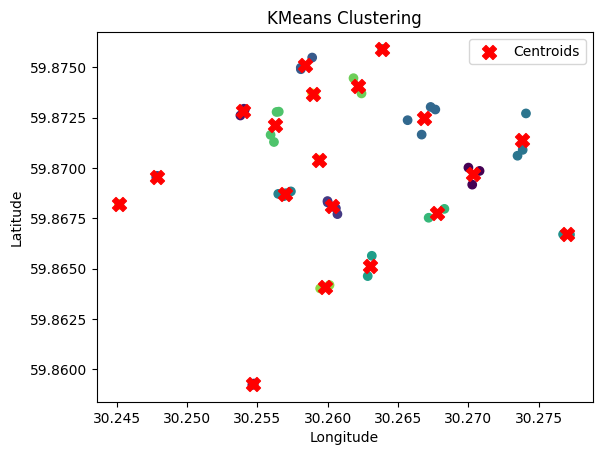

In [ ]:
coordinates = data[['LATITUDE', 'LONGITUDE']]

the_best_kmeans_model = None
the_best_silhouette_score = 0
the_best_n_clusters = 0

for n in range(2, 20):
  kmeans = KMeans(n_clusters=n, random_state=0)
  data['cluster'] = kmeans.fit_predict(coordinates)
  current_silhouette_score = silhouette_score(coordinates, data['cluster'], metric='haversine')
  if current_silhouette_score > the_best_silhouette_score:
    the_best_silhouette_score = current_silhouette_score
    the_best_kmeans_model = kmeans
    the_best_n_clusters = n

data['cluster'] = the_best_kmeans_model.fit_predict(coordinates)

print(data[['ID_STOP', 'STOP_NAME', 'LATITUDE', 'LONGITUDE', 'cluster']])

plt.scatter(data['LONGITUDE'], data['LATITUDE'], c=data['cluster'], cmap='viridis', marker='o')
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 0], s=100, c='red', marker='X', label='Centroids')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('KMeans Clustering')
plt.legend()
plt.show()

In [ ]:
print(round(silhouette_score(coordinates, data['cluster']), 2))

0.72


In [ ]:
map_center = [data['LATITUDE'].mean(), data['LONGITUDE'].mean()]
mymap = folium.Map(location=map_center, zoom_start=12)

for index, row in data.iterrows():
    folium.Marker(location=[row['LATITUDE'], row['LONGITUDE']],
                  popup=f"{row['STOP_NAME']} (Cluster {row['cluster']})",
                  icon=folium.Icon(color='blue')).add_to(mymap)

for center in kmeans.cluster_centers_:
    folium.Marker(location=[center[0], center[1]],
                  popup="Cluster Center",
                  icon=folium.Icon(color='red')).add_to(mymap)

display(mymap)

# Алгоритм DBSCAN

In [ ]:
# latitude, longitude = list(coordinates.LATITUDE), list(coordinates.LONGITUDE)
# neighbors = {}
# for i in range(len(latitude)):
#   dist = []
#   for j in range(len(latitude)):
#     if i != j:
#       d = coordinate_distance(latitude[i], longitude[i], latitude[j], longitude[j])
#       dist.append(d)
#   dist.sort()
#   neighbors[i] = dist

# k = 5
# k_neighbors = [neighbors[i][k] for i in range(len(latitude))]
# print(max(k_neighbors))
# k_neighbors.sort()
# plt.plot([i for i in range(len(latitude))], k_neighbors)

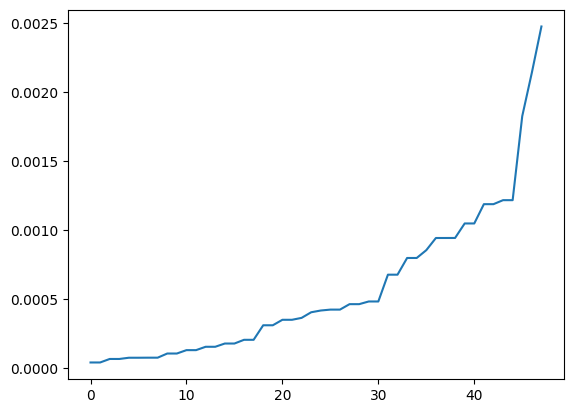

In [ ]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=3, metric='haversine')
nn.fit(data[['LATITUDE', 'LONGITUDE']])
distances, indices = nn.kneighbors(data[['LATITUDE', 'LONGITUDE']])

distances = distances[:, 1]
distances.sort()

plt.plot(distances)
plt.show()

In [ ]:
EPS = 0.0025
MIN_SAMPLES = 2

dbscan = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES, metric='haversine')
data['cluster'] = dbscan.fit_predict(data[['LATITUDE', 'LONGITUDE']])

      ID_STOP                                          STOP_NAME   LATITUDE  \
115      1341                                 АВТОВСКАЯ УЛ. [72]  59.869850   
224     14715           УЛ .ЗЕНИТЧИКОВ [66, 72, 2, 20, 200, 229]  59.874457   
258     14813   УЛ. ЗЕНИТЧИКОВ [66, 72, 2, 20, 200, 229] [тест]<  59.873700   
437      1507                  ДОРОГА НА ТУРУХТАННЫЕ ОСТРОВА [2]  59.869534   
603     15238                               Проспект Стачек (20)  59.859285   
607     15241                            "Метро ""Автово"" (20)"  59.867703   
609     15243             Комсомольская площадь (20, 41, 46, 48)  59.873703   
650     15285             Комсомольская площадь (20, 41, 46, 48)  59.874903   
654     15289                                 Улица Зайцева (20)  59.870412   
657     15291                            "Метро ""Автово"" (20)"  59.868351   
1142    15797                   Кронштадтская улица (41, 46, 48)  59.872890   
1144    15799         Дорога на Турухтанные острова 

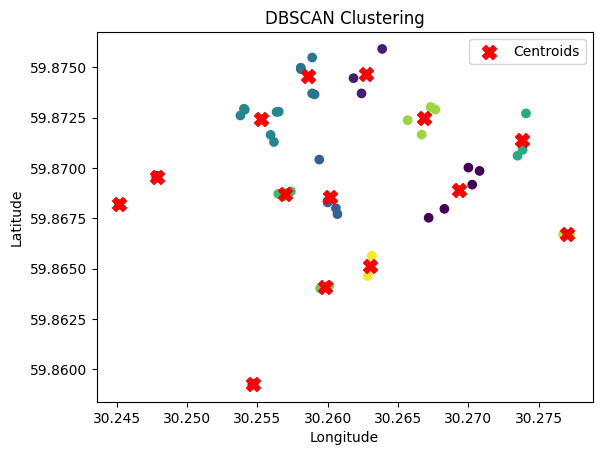

In [ ]:
# def geodesic_distance(coord1, coord2):
#     return geodesic(coord1, coord2).meters

# the_best_dbscan_model = None
# the_best_centers_count = 0

# for epsilon in range(400, 450):
#   print(epsilon)
#   dbscan = DBSCAN(eps=epsilon, min_samples=5, metric=geodesic_distance)
#   data['cluster'] = dbscan.fit_predict(coordinates)
#   # if len(list(dbscan.labels_)) != list(dbscan.labels_).count(-1):
#   #   print(epsilon)
#   #   break
#   if len(set(dbscan.labels_)) > the_best_centers_count:
#     the_best_dbscan_model = dbscan


# data['cluster'] = the_best_dbscan_model.fit_predict(coordinates)

print(data[['ID_STOP', 'STOP_NAME', 'LATITUDE', 'LONGITUDE', 'cluster']])

cluster_centers = data.groupby('cluster')[['LATITUDE', 'LONGITUDE']].mean().reset_index()

plt.scatter(data['LONGITUDE'], data['LATITUDE'], c=data['cluster'], cmap='viridis', marker='o')
plt.scatter(cluster_centers['LONGITUDE'], cluster_centers['LATITUDE'], s=100, c='red', marker='X', label='Centroids')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clustering')
plt.legend()
plt.show()

In [ ]:
print(round(silhouette_score(coordinates, data['cluster'], metric='haversine'), 2))

0.68


In [ ]:
cluster_centers = data.groupby('cluster')[['LATITUDE', 'LONGITUDE']].mean().reset_index()

map_center = [data['LATITUDE'].mean(), data['LONGITUDE'].mean()]
mymap = folium.Map(location=map_center, zoom_start=12)

for index, row in data.iterrows():
    folium.Marker(location=[row['LATITUDE'], row['LONGITUDE']],
                  popup=f"{row['STOP_NAME']} (Cluster {row['cluster']})",
                  icon=folium.Icon(color='blue')).add_to(mymap)

for index, row in cluster_centers.iterrows():
    folium.Marker(location=[row['LATITUDE'], row['LONGITUDE']],
                  popup=f"Cluster Center {row['cluster']}",
                  icon=folium.Icon(color='red')).add_to(mymap)

display(mymap)